In [69]:
import utils.utils as utils
import utils.datasets as datasets
import utils.traditional_methods as tm

import numpy as np
from numba import jit
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.nn.parameter import Parameter
from torch.nn.init import xavier_normal_
import torch.optim as optim
from sklearn.metrics import f1_score, confusion_matrix

pd.set_option('display.max_columns', 50)
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [70]:
df, load_data = datasets.megc("raw")
#lbptop_features = np.load("../data/lbptop_megc_cropped.npy")
#lbptop_features = tm.calculate_lbptop(df, load_data)
#mdmo_features = tm.calculate_mdmo(df, load_data)
mdmo_features = np.load("../data/mdmo_megc_cropped.npy")

/home/tvaranka/.local/lib/python3.6/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [71]:
video = next(load_data)

In [75]:
out = tm.tim(video, 50)

False

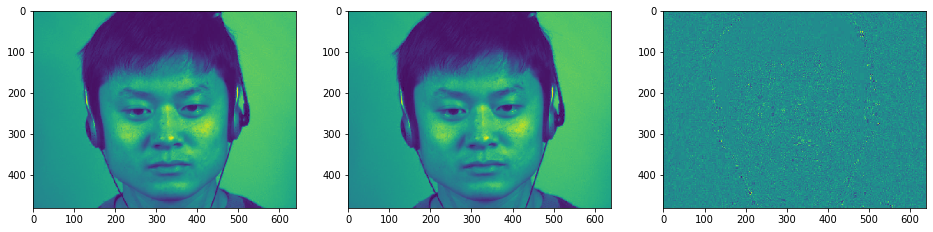

In [103]:
fig, ax = plt.subplots(1, 3, figsize=(16, 8))
idx = 10
ax[0].imshow(video[..., idx])
ax[1].imshow(out[..., idx])
ax[2].imshow(video[..., idx] - out[..., idx])
np.allclose(video[..., idx], out[..., idx])

In [65]:
mask = np.ones(445)
mask[[17, 26, 130]] = 0
mdmo_features = mdmo_features[mask == 1]

In [66]:
beta = 0.8235980614260203
mdmo_features[:, :36] = beta * mdmo_features[:, :36]
mdmo_features[:, 36:] = (1 - beta) * mdmo_features[:, 36:]

In [67]:
svm = SVC(gamma=0.2691354169665958, C=28.06195010184402)

lbptop svm = SVC(kernel="poly", gamma="auto")

lbptop loaded features
Total f1: 0.6014768747661717, SMIC: 0.5825297308055929, CASME2: 0.696011396011396, SAMM: 0.36996504027967775
lbptop calculated features
Total f1: 0.6106660236194306, SMIC: 0.5797835497835498, CASME2: 0.7208282991005505, SAMM: 0.27259259259259255

In [68]:
LOSO(svm, mdmo_features, df)

Subject: 006, n=11| test_f1: 0.20833
Subject: 007, n=08| test_f1: 0.22222
Subject: 009, n=04| test_f1: 0.22222
Subject: 01, n=03| test_f1: 1.0
Subject: 010, n=04| test_f1: 1.0
Subject: 011, n=20| test_f1: 0.28095
Subject: 012, n=03| test_f1: 0.16667
Subject: 013, n=06| test_f1: 1.0
Subject: 014, n=10| test_f1: 0.14074
Subject: 015, n=03| test_f1: 0.33333
Subject: 016, n=05| test_f1: 0.11111
Subject: 017, n=04| test_f1: 0.22222
Subject: 018, n=03| test_f1: 0.4
Subject: 019, n=01| test_f1: 1.0
Subject: 02, n=09| test_f1: 0.4127
Subject: 020, n=04| test_f1: 0.38889
Subject: 021, n=02| test_f1: 0.0
Subject: 022, n=05| test_f1: 0.7619
Subject: 023, n=01| test_f1: 1.0
Subject: 024, n=01| test_f1: 0.0
Subject: 026, n=09| test_f1: 0.26667
Subject: 028, n=03| test_f1: 0.0
Subject: 03, n=05| test_f1: 1.0
Subject: 030, n=03| test_f1: 0.0
Subject: 031, n=01| test_f1: 1.0
Subject: 032, n=04| test_f1: 0.33333
Subject: 033, n=05| test_f1: 0.11111
Subject: 034, n=03| test_f1: 1.0
Subject: 035, n=08| t

In [10]:
def LOSO(clf, features, df, verbose=True):
    outputs_list = []
    #groupby reorders elements, now the labels are in same order as outputs
    df_groupby = pd.concat([i[1] for i in df.groupby("subject")])
    dataset_groupby = df_groupby["dataset"]
    
    labels = df["emotion"]
    labels_groupby = df_groupby["emotion"]

    #loop over each subject
    for group in df.groupby("subject"):
        subject = group[0]
        #split data to train and test based on the subject index
        train_index = df[df["subject"] != subject].index
        X_train = features[train_index, :]
        y_train = labels[train_index]
        
        test_index = df[df["subject"] == subject].index
        X_test = features[test_index, :]
        y_test = labels[test_index]  
        
        clf.fit(X_train, y_train)
        
        prediction = clf.predict(X_test)
        outputs_list.append(prediction)
        test_f1 = f1_score(y_test, prediction, average="macro")
        #Print statistics
        if verbose:
            print("Subject: {}, n={}| test_f1: {:.5}".format(
                subject, str(y_test.shape[0]).zfill(2), test_f1))
            
    outputs = np.concatenate(outputs_list)
    f1_total = f1_score(labels_groupby, outputs, average="macro")
    idx = dataset_groupby == "smic"
    f1_smic = f1_score(labels_groupby[idx], outputs[idx], average="macro")
    idx = dataset_groupby == "casme2"
    f1_casme2 = f1_score(labels_groupby[idx], outputs[idx], average="macro")
    idx = dataset_groupby == "samm"
    f1_samm = f1_score(labels_groupby[idx], outputs[idx], average="macro")
    print("Total f1: {}, SMIC: {}, CASME2: {}, SAMM: {}".format(f1_total, f1_smic, f1_casme2, f1_samm))